In [1]:
# Imports
import pandas as pd
import sqlite3
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from matplotlib import pyplot as plt


%matplotlib inline

In [2]:
# Establish a connection to the SQLite3 database
conn = sqlite3.connect('data\im.db')

In [3]:
# Explore the data structure and primary keys
master_table = pd.read_sql("""
SELECT *
FROM sqlite_master
WHERE type = 'table'
""", conn)
master_table

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [4]:
# Explore each table's contents
print("movie_basics")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM movie_basics
LIMIT 5
""", conn))

print("directors")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM directors
LIMIT 5
""", conn))

print("known_for")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM known_for
LIMIT 5
""", conn))

print("movie_akas")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM movie_akas
LIMIT 5
""", conn))

print("movie_ratings")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM movie_ratings
LIMIT 5
""", conn))

print("persons")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM persons
LIMIT 5
""", conn))

print("principals")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM principals
LIMIT 5
""", conn))

print("writers")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM writers
LIMIT 5
""", conn))

movie_basics


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,COUNT(*)
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",146144


directors


,movie_id,person_id,COUNT(*)
0,tt0285252,nm0899854,291174


known_for


,person_id,movie_id,COUNT(*)
0,nm0061671,tt0837562,1638260


movie_akas


,movie_id,ordering,title,region,language,types,attributes,is_original_title,COUNT(*)
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0,331703


movie_ratings


,movie_id,averagerating,numvotes,COUNT(*)
0,tt10356526,8.3,31,73856


persons


,person_id,primary_name,birth_year,death_year,primary_profession,COUNT(*)
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer",606648


principals


,movie_id,ordering,person_id,category,job,characters,COUNT(*)
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]",1028186


writers


,movie_id,person_id,COUNT(*)
0,tt0285252,nm0899854,255873


Notes:
- SELECT * (movie titles, year, runtime, and genres) FROM movie_basics table by connecting with movie_id
- JOIN movie_ratings USING(movie_id)

In [5]:
df = pd.read_csv('data/tn.movie_budgets.csv')
df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [7]:
df.describe(include='object')

,release_date,movie,production_budget,domestic_gross,worldwide_gross
count,5782,5782,5782,5782,5782
unique,2418,5698,509,5164,5356
top,"Dec 31, 2014",Halloween,"$20,000,000",$0,$0
freq,24,3,231,548,367


Notes:
- Movies will need to be matched with movie_id while accounting for alternate titles
- CSV includes release date (not just year), budget, domestic gross, worldwide gross

Potential routes of analysis:
- ROI per genre (if wanting best return on investment)
- Ratings per genre (if seeking awards)
- ROI by budget level (to determine a reasonable budget -- Low: <$5M, Medium: $5-50M, High: >$50M)
- ROI by length of movie (to determine best timeframe -- Short: <90 mins, Medium: 90-120 mins, Long: >120 mins)
- Revenue by release month (to determine best month for release)

In [8]:
# Consolidate into one dataframe
# First combine the SQL tables
sql_movies = pd.read_sql("""
SELECT *
FROM movie_basics
    JOIN movie_ratings
        USING(movie_id)
""", conn)

sql_movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [9]:
sql_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [10]:
alt_titles = pd.read_sql("""
SELECT *
FROM movie_akas
""", conn)
alt_titles.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [11]:
alt_titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


In [12]:
# Create a dictionary so that we can match alternate movie titles to the correct movie_id
alt_dict = dict(zip(alt_titles['title'], alt_titles['movie_id']))
len(alt_dict)

252781

In [13]:
# Create a 'movie_id' column in our dataframe by using the map method
# First, create a dictionary of the accepted inputs and desired outputs
alt_dict = dict(zip(alt_titles['title'], alt_titles['movie_id']))

# Then call the method
df['movie_id'] = df['movie'].map(alt_dict)
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",NaN
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,tt7837402
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",NaN
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",NaN
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,tt2107644


In [14]:
merge_df = pd.merge(sql_movies, df, on='movie_id')
merge_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,tt0339736,The Evil Within,The Evil Within,2017,98.0,Horror,5.6,2420,43,"Oct 10, 2014",Whiplash,"$3,300,000","$13,092,006","$38,969,037"
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,"$91,000,000","$58,236,838","$187,861,183"
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,"$28,000,000","$26,017,685","$62,108,587"
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864"


In [15]:
"""
Function to replace '$' and commas from 'production_budget', 'domestic_gross', 'worldwide_gross'
Takes in dataframe and column names
Returns cleaned version saved over the original dataframe
"""

def clean_currency_columns(df, columns):
    for column in columns:
        df.loc[:, column] = df[column].replace({'\$': '', ',': ''}, regex=True).astype(float)
    return df

In [16]:
# Defines the columns to clean
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']

# Calls the function
merge_df = clean_currency_columns(merge_df, columns_to_clean)
merge_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0
1,tt0339736,The Evil Within,The Evil Within,2017,98.0,Horror,5.6,2420,43,"Oct 10, 2014",Whiplash,3300000.0,13092006.0,38969037.0
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,28000000.0,26017685.0,62108587.0
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1648854864.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,tt9225192,Unstoppable,Seongnan hwangso,2018,116.0,"Action,Crime",6.5,576,1,"Nov 14, 1980",Raging Bull,18000000.0,23380203.0,23380203.0
2188,tt9392532,Neighbors,Neighbors,2018,90.0,"Comedy,Drama",7.6,18,64,"May 9, 2014",Neighbors,18000000.0,150086800.0,270944428.0
2189,tt9415552,Tankers,Nesokrushimyy,2018,90.0,"Action,Drama,History",5.7,1031,27,"Aug 25, 2006",Invincible,40000000.0,57806952.0,58501127.0
2190,tt9680064,Walter,Walter,2019,90.0,Comedy,6.4,35,96,"Mar 13, 2015",Walter,700000.0,0.0,0.0


In [17]:
"""
Function used to compare 'domestic_gross' and 'worldwide_gross' and return the higher value
Takes in dataframe and column names
Returns cleaned version saved over the original dataframe
"""

def calculate_revenue(row):
    if row['domestic_gross'] >= row['worldwide_gross']:
        return row['domestic_gross']
    else:
        return row['worldwide_gross']

merge_df['revenue'] = merge_df.apply(calculate_revenue, axis=1)
merge_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,revenue
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0,7.370600e+04
1,tt0339736,The Evil Within,The Evil Within,2017,98.0,Horror,5.6,2420,43,"Oct 10, 2014",Whiplash,3300000.0,13092006.0,38969037.0,3.896904e+07
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,1.878612e+08
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,28000000.0,26017685.0,62108587.0,6.210859e+07
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1648854864.0,1.648855e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,tt9225192,Unstoppable,Seongnan hwangso,2018,116.0,"Action,Crime",6.5,576,1,"Nov 14, 1980",Raging Bull,18000000.0,23380203.0,23380203.0,2.338020e+07
2188,tt9392532,Neighbors,Neighbors,2018,90.0,"Comedy,Drama",7.6,18,64,"May 9, 2014",Neighbors,18000000.0,150086800.0,270944428.0,2.709444e+08
2189,tt9415552,Tankers,Nesokrushimyy,2018,90.0,"Action,Drama,History",5.7,1031,27,"Aug 25, 2006",Invincible,40000000.0,57806952.0,58501127.0,5.850113e+07
2190,tt9680064,Walter,Walter,2019,90.0,Comedy,6.4,35,96,"Mar 13, 2015",Walter,700000.0,0.0,0.0,0.000000e+00


In [18]:
relevant_cols = [
    'primary_title',
    'runtime_minutes',
    'genres',
    'averagerating',
    "release_date",
    'production_budget',
    'revenue'
]

df_relevant = merge_df[relevant_cols]
df_relevant

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue
0,Foodfight!,91.0,"Action,Animation,Comedy",1.9,"Dec 31, 2012",45000000.0,7.370600e+04
1,The Evil Within,98.0,Horror,5.6,"Oct 10, 2014",3300000.0,3.896904e+07
2,The Secret Life of Walter Mitty,114.0,"Adventure,Comedy,Drama",7.3,"Dec 25, 2013",91000000.0,1.878612e+08
3,A Walk Among the Tombstones,114.0,"Action,Crime,Drama",6.5,"Sep 19, 2014",28000000.0,6.210859e+07
4,Jurassic World,124.0,"Action,Adventure,Sci-Fi",7.0,"Jun 12, 2015",215000000.0,1.648855e+09
...,...,...,...,...,...,...,...
2187,Unstoppable,116.0,"Action,Crime",6.5,"Nov 14, 1980",18000000.0,2.338020e+07
2188,Neighbors,90.0,"Comedy,Drama",7.6,"May 9, 2014",18000000.0,2.709444e+08
2189,Tankers,90.0,"Action,Drama,History",5.7,"Aug 25, 2006",40000000.0,5.850113e+07
2190,Walter,90.0,Comedy,6.4,"Mar 13, 2015",700000.0,0.000000e+00


In [19]:
# Return on Investent (roi) is a percentage gain (or loss) of the initial budget that the movie brought in
df_relevant.loc[:, 'roi'] = ((df_relevant['revenue'] - df_relevant['production_budget']) / df_relevant['production_budget'] * 100).astype(float)
df_relevant

C:\Users\Elija\AppData\Local\Temp\ipykernel_28536\890075838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant.loc[:, 'roi'] = ((df_relevant['revenue'] - df_relevant['production_budget']) / df_relevant['production_budget'] * 100).astype(float)


,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"Action,Animation,Comedy",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Evil Within,98.0,Horror,5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909
2,The Secret Life of Walter Mitty,114.0,"Adventure,Comedy,Drama",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860
3,A Walk Among the Tombstones,114.0,"Action,Crime,Drama",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
4,Jurassic World,124.0,"Action,Adventure,Sci-Fi",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
...,...,...,...,...,...,...,...,...
2187,Unstoppable,116.0,"Action,Crime",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017
2188,Neighbors,90.0,"Comedy,Drama",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822
2189,Tankers,90.0,"Action,Drama,History",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817
2190,Walter,90.0,Comedy,6.4,"Mar 13, 2015",700000.0,0.000000e+00,-100.000000


In [20]:
# Split 'genres' to make lists. Then use explode to list each title under each genre
df_relevant.loc[:, 'genres'] = df_relevant['genres'].str.split(',')
df_genre = df_relevant.explode('genres')
df_genre.head()

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,Action,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Animation,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Comedy,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
1,The Evil Within,98.0,Horror,5.6,"Oct 10, 2014",3300000.0,38969037.0,1080.879909
2,The Secret Life of Walter Mitty,114.0,Adventure,7.3,"Dec 25, 2013",91000000.0,187861183.0,106.440860


In [21]:
# Only a handful of nulls in runtime and in genres
df_relevant.isna().sum()

primary_title         0
runtime_minutes      65
genres                5
averagerating         0
release_date          0
production_budget     0
revenue               0
roi                   0
dtype: int64

In [22]:
genre_counts = df_genre['genres'].value_counts()
genre_counts

genres
Drama          1092
Comedy          658
Action          544
Adventure       413
Thriller        352
Crime           299
Horror          288
Romance         244
Sci-Fi          169
Biography       167
Mystery         158
Fantasy         156
Documentary     131
Family          125
Animation       120
Music            65
History          65
Sport            49
War              39
Musical          19
Western          16
News              5
Name: count, dtype: int64

In [23]:
valid_genres = genre_counts[genre_counts >= 30].index

filtered_df_genre = df_genre[df_genre['genres'].isin(valid_genres)]
filtered_df_genre

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,Action,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Animation,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Comedy,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
1,The Evil Within,98.0,Horror,5.6,"Oct 10, 2014",3300000.0,38969037.0,1080.879909
2,The Secret Life of Walter Mitty,114.0,Adventure,7.3,"Dec 25, 2013",91000000.0,187861183.0,106.440860
...,...,...,...,...,...,...,...,...
2189,Tankers,90.0,History,5.7,"Aug 25, 2006",40000000.0,58501127.0,46.252817
2190,Walter,90.0,Comedy,6.4,"Mar 13, 2015",700000.0,0.0,-100.000000
2191,Alive,95.0,Adventure,7.1,"Jan 15, 1993",32000000.0,36299670.0,13.436469
2191,Alive,95.0,Biography,7.1,"Jan 15, 1993",32000000.0,36299670.0,13.436469


In [24]:
# Exclude genres that have less than 30 movies
ratings_by_genre = filtered_df_genre.groupby('genres')['averagerating'].mean().round(1).reset_index()
ratings_by_genre = ratings_by_genre.sort_values(by='averagerating', ascending=False)
ratings_by_genre

,genres,averagerating
6,Documentary,7.1
3,Biography,6.9
10,History,6.7
18,War,6.6
16,Sport,6.6
12,Music,6.4
2,Animation,6.4
7,Drama,6.4
1,Adventure,6.4
14,Romance,6.3


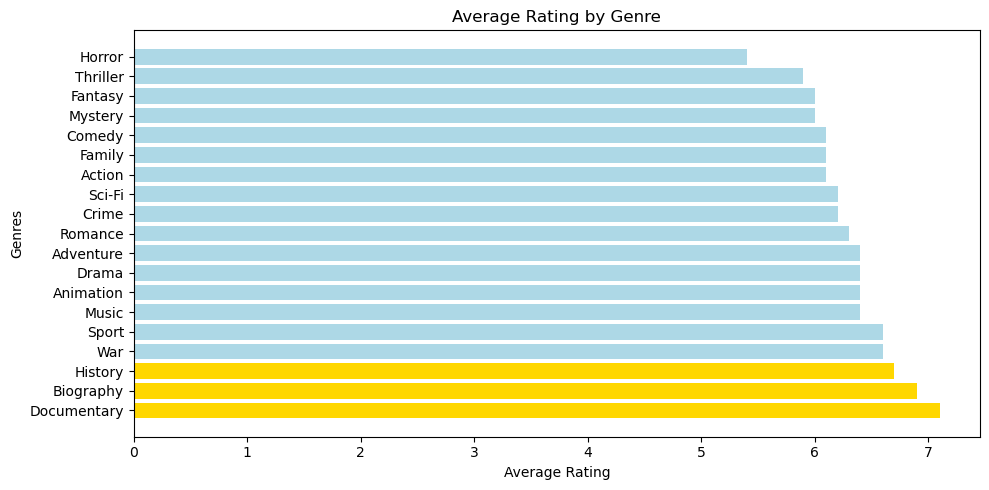

In [25]:
colors = ['gold' if i < 3 else 'lightblue' for i in range(len(ratings_by_genre))]

x =ratings_by_genre['genres']
y = ratings_by_genre['averagerating']

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(x, y, color=colors)
ax.set_title('Average Rating by Genre')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Genres')
plt.tight_layout();

Because we have multiple genres and we are comparing the average rating between each I will use an ANOVA test.

H0: There is no significant difference in average rating between genres.

H1: There is a significant difference in average rating between genres.

alpha = 0.05

In [26]:
# Group the data by valid genres and collect ratings
rec3_grouped_data = filtered_df_genre.groupby('genres')['averagerating'].apply(list)

# Extract groups for ANOVA
rec3_groups = [ratings for ratings in rec3_grouped_data]

# Perform the ANOVA test if there are valid groups
f_statistic, p_value = stats.f_oneway(*rec3_groups)

# Interpret the results
alpha = 0.05  # Significance level
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences between genre ratings.")
else:
    print("Fail to reject the null hypothesis: No significant differences between genre ratings.")

F-statistic: 25.36099623843255
P-value: 1.0855757551287297e-81
Reject the null hypothesis: There are significant differences between genre ratings.


In [27]:
# Run Tukey's HSD test
rec3_tk_hsd = pairwise_tukeyhsd(endog=filtered_df_genre['averagerating'], 
                            groups=filtered_df_genre['genres'], 
                            alpha=0.05)

# Display the summary of results
print(rec3_tk_hsd.summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
     Action   Adventure   0.2512 0.0377   0.006  0.4964   True
     Action   Animation   0.3136 0.2641 -0.0653  0.6926  False
     Action   Biography   0.8238    0.0  0.4913  1.1562   True
     Action      Comedy    0.008    1.0 -0.2098  0.2257  False
     Action       Crime   0.0532    1.0 -0.2173  0.3237  False
     Action Documentary   0.9516    0.0  0.5859  1.3173   True
     Action       Drama   0.3322    0.0   0.135  0.5294   True
     Action      Family  -0.0108    1.0 -0.3835   0.362  False
     Action     Fantasy  -0.0696    1.0 -0.4108  0.2717  False
     Action     History   0.5913 0.0037  0.0982  1.0845   True
     Action      Horror   -0.674    0.0 -0.9478 -0.4002   True
     Action       Music   0.2821 0.8817  -0.211  0.7752  False
     Action     Mystery  -0.1562 0.9842 -0.4958  0.1834

In [28]:
"""
The results of this table show the combinations of movies that have statistically
higher ratings than the average. If wanting to create a multi-genre movie, it is 
suggested to use one of the pairs (group1 and group2) below.
"""

rec3_results = pd.DataFrame(data=rec3_tk_hsd._results_table.data[1:], 
                          columns=rec3_tk_hsd._results_table.data[0])
rec3_results.query('reject == True and (group1 == "History" or group1 == "Documentary" or group1 == "Biography")')

,group1,group2,meandiff,p-adj,lower,upper,reject
51,Biography,Comedy,-0.8158,0.0000,-1.1414,-0.4902,True
52,Biography,Crime,-0.7706,0.0000,-1.1336,-0.4075,True
54,Biography,Drama,-0.4916,0.0000,-0.8038,-0.1794,True
55,Biography,Family,-0.8345,0.0000,-1.2789,-0.3901,True
56,Biography,Fantasy,-0.8933,0.0000,-1.3117,-0.4749,True
58,Biography,Horror,-1.4978,0.0000,-1.8632,-1.1323,True
60,Biography,Mystery,-0.9800,0.0000,-1.3970,-0.5630,True
61,Biography,Romance,-0.6815,0.0000,-1.0589,-0.3041,True
62,Biography,Sci-Fi,-0.7165,0.0000,-1.1265,-0.3065,True
64,Biography,Thriller,-1.0452,0.0000,-1.3983,-0.6922,True


Recommendation 1: Create a historical movie, a biography, or a documentary.

Next area of focus: ROI by budget level (to determine a reasonable budget -- Low: <$5M, Medium: $5-50M, High: >$50M)

In [29]:
df_relevant

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Evil Within,98.0,[Horror],5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909
2,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860
3,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
4,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
...,...,...,...,...,...,...,...,...
2187,Unstoppable,116.0,"[Action, Crime]",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017
2188,Neighbors,90.0,"[Comedy, Drama]",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822
2189,Tankers,90.0,"[Action, Drama, History]",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817
2190,Walter,90.0,[Comedy],6.4,"Mar 13, 2015",700000.0,0.000000e+00,-100.000000


In [30]:
# We need to drop films that did not bring in any revenue so that it does not skew our data.
df_relevant.loc[df_relevant['revenue'] == 0]

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
6,Anderson's Cross,98.0,"[Comedy, Drama, Romance]",5.5,"Dec 31, 2010",300000.0,0.0,-100.0
26,House at the End of the Drive,91.0,"[Horror, Thriller]",6.5,"Dec 31, 2014",1400000.0,0.0,-100.0
39,Barry Munday,95.0,"[Comedy, Drama, Romance]",5.9,"Oct 1, 2010",3000000.0,0.0,-100.0
99,The Dead Undead,89.0,"[Action, Horror, Sci-Fi]",3.0,"Dec 31, 2010",1100000.0,0.0,-100.0
102,Freaky Deaky,90.0,"[Comedy, Crime, Thriller]",6.1,"Dec 31, 2011",6000000.0,0.0,-100.0
...,...,...,...,...,...,...,...,...
2137,Rust,100.0,[Drama],6.6,"Oct 5, 2010",250000.0,0.0,-100.0
2152,Red 11,77.0,"[Horror, Sci-Fi, Thriller]",5.6,"Dec 31, 2018",7000.0,0.0,-100.0
2164,Blinded by the Light,117.0,"[Biography, Comedy, Drama]",6.2,"Aug 14, 2019",15000000.0,0.0,-100.0
2185,Butterfly,80.0,"[Documentary, Sport]",7.8,"Dec 31, 2010",250000.0,0.0,-100.0


In [31]:
# Drop rows where revenue = 0
df_pos_rev = df_relevant.loc[df_relevant['revenue'] != 0]
df_pos_rev

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Evil Within,98.0,[Horror],5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909
2,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860
3,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
4,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
...,...,...,...,...,...,...,...,...
2186,The Villagers,99.0,"[Action, Thriller]",5.7,"Sep 19, 1980",6000000.0,5.230298e+07,771.716300
2187,Unstoppable,116.0,"[Action, Crime]",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017
2188,Neighbors,90.0,"[Comedy, Drama]",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822
2189,Tankers,90.0,"[Action, Drama, History]",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817


In [32]:
# Check we only dropped rows where revenue = 0
2192 - 201

1991

In [33]:
# Low: <$5M, Medium: $5-50M, High: >$50M
def assign_budget_level(revenue):
    if revenue < 5000000:
        return 'Low'
    elif 5000000 <= revenue <= 50000000:
        return 'Medium'
    else:
        return 'High'

In [34]:
# df['movie_id'] = df['movie'].map(alt_dict)
df_pos_rev.loc[:, 'budget_level'] = df_pos_rev['revenue'].map(assign_budget_level)
df_pos_rev

C:\Users\Elija\AppData\Local\Temp\ipykernel_28536\3342494519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_rev.loc[:, 'budget_level'] = df_pos_rev['revenue'].map(assign_budget_level)


,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi,budget_level
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209,Low
1,The Evil Within,98.0,[Horror],5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909,Medium
2,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860,High
3,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382,High
4,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239,High
...,...,...,...,...,...,...,...,...,...
2186,The Villagers,99.0,"[Action, Thriller]",5.7,"Sep 19, 1980",6000000.0,5.230298e+07,771.716300,High
2187,Unstoppable,116.0,"[Action, Crime]",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017,Medium
2188,Neighbors,90.0,"[Comedy, Drama]",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822,High
2189,Tankers,90.0,"[Action, Drama, History]",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817,High


C:\Users\Elija\AppData\Local\Temp\ipykernel_28536\1550319642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_rev['budget_level'] = pd.Categorical(df_pos_rev['budget_level'], categories=order, ordered=True)


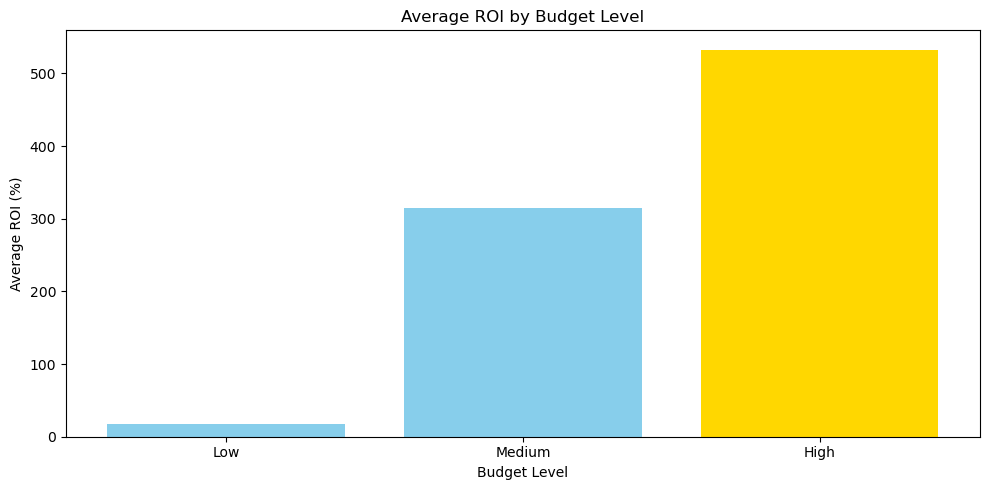

In [35]:
# Convert 'budget_level' to a categorical type with the specific order
order = ['Low', 'Medium', 'High']
df_pos_rev['budget_level'] = pd.Categorical(df_pos_rev['budget_level'], categories=order, ordered=True)

# Calculate the average ROI per budget level
average_roi = df_pos_rev.groupby('budget_level')['roi'].mean().reset_index()
average_roi = average_roi.sort_values('budget_level')

# Find the maximum average ROI
max_average_roi = average_roi['roi'].max()

# Determine the colors: gold for the highest average ROI, others in blue
colors = ['gold' if roi == max_average_roi else 'skyblue' for roi in average_roi['roi']]

# Define x and y for plotting
x = average_roi['budget_level']
y = average_roi['roi']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x, y, color=colors)
ax.set_title('Average ROI by Budget Level')
ax.set_xlabel('Budget Level')
ax.set_ylabel('Average ROI (%)')
plt.tight_layout();

Because we have multiple genres and we are comparing the average rating between each I will use an ANOVA test.


H0: Average ROI is not significantly different between low budget, medium budget, and high budget films.

H1: Average ROI is significantly different between low budget, medium budget, and high budget films.

alpha = 0.05

In [36]:
# Group the data by valid genres and collect ratings
rec2_grouped_data = df_pos_rev.groupby('budget_level')['roi'].apply(list)

# Extract groups for ANOVA
rec2_groups = [roi for roi in rec2_grouped_data]

# Perform the ANOVA test if there are valid groups
f_statistic, p_value = stats.f_oneway(*rec2_groups)

# Interpret the results
alpha = 0.05  # Significance level
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences between genre ratings.")
else:
    print("Fail to reject the null hypothesis: No significant differences between genre ratings.")

F-statistic: 14.304973343890405
P-value: 6.787475056997664e-07
Reject the null hypothesis: There are significant differences between genre ratings.


In [39]:
# Run Tukey's HSD test
rec2_tk_hsd = pairwise_tukeyhsd(endog=df_pos_rev['roi'], 
                            groups=df_pos_rev['budget_level'], 
                            alpha=0.05)

# Display the summary of results
print(rec2_tk_hsd.summary())

"""
The results of this table show that at each increasing budget level there is
a statistically significant difference in return on investment.
"""

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
  High    Low -514.9979    0.0  -743.242 -286.7538   True
  High Medium -218.2949 0.0277 -417.6319   -18.958   True
   Low Medium   296.703 0.0128   51.3797  542.0263   True
---------------------------------------------------------


'\nThe results of this table show that at each increasing budget level there is\na statistically significant difference in return on investment.\n'

Recommendation 2: Secure a minimum production budget of $5M (the more funding the better)

Next area of focus: Revenue by release month (to determine best month for release)

In [40]:
df_relevant

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Evil Within,98.0,[Horror],5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909
2,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860
3,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
4,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
...,...,...,...,...,...,...,...,...
2187,Unstoppable,116.0,"[Action, Crime]",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017
2188,Neighbors,90.0,"[Comedy, Drama]",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822
2189,Tankers,90.0,"[Action, Drama, History]",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817
2190,Walter,90.0,[Comedy],6.4,"Mar 13, 2015",700000.0,0.000000e+00,-100.000000


In [41]:
df_relevant.loc[:, 'release_month'] = df_relevant['release_date'].str.slice(0,3)
df_relevant

C:\Users\Elija\AppData\Local\Temp\ipykernel_28536\3100926059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant.loc[:, 'release_month'] = df_relevant['release_date'].str.slice(0,3)


,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi,release_month
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209,Dec
1,The Evil Within,98.0,[Horror],5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909,Oct
2,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860,Dec
3,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382,Sep
4,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239,Jun
...,...,...,...,...,...,...,...,...,...
2187,Unstoppable,116.0,"[Action, Crime]",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017,Nov
2188,Neighbors,90.0,"[Comedy, Drama]",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822,May
2189,Tankers,90.0,"[Action, Drama, History]",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817,Aug
2190,Walter,90.0,[Comedy],6.4,"Mar 13, 2015",700000.0,0.000000e+00,-100.000000,Mar


In [42]:
revenue_by_month = df_relevant.groupby('release_month')['revenue'].mean().reset_index()
revenue_by_month

,release_month,revenue
0,Apr,9.596150e+07
1,Aug,7.263313e+07
2,Dec,1.165882e+08
3,Feb,1.019795e+08
4,Jan,6.589613e+07
5,Jul,1.571820e+08
6,Jun,1.803984e+08
7,Mar,1.183016e+08
8,May,1.837455e+08
9,Nov,1.570913e+08


In [43]:
# Define the correct month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Convert the 'release_month' column to a categorical type with the correct order
df_relevant['release_month'] = pd.Categorical(df_relevant['release_month'], categories=month_order, ordered=True)

# Now, group by 'release_month' and calculate the mean revenue
revenue_by_month = df_relevant.groupby('release_month')['revenue'].mean().reset_index()

# Convert revenue from dollars to millions of dollars
revenue_by_month['revenue'] = round(revenue_by_month['revenue'] / 1000000, 1)

# Sort the DataFrame by the categorical month order
revenue_by_month = revenue_by_month.sort_values('release_month')
print(revenue_by_month)

   release_month  revenue
0            Jan     65.9
1            Feb    102.0
2            Mar    118.3
3            Apr     96.0
4            May    183.7
5            Jun    180.4
6            Jul    157.2
7            Aug     72.6
8            Sep     60.1
9            Oct     64.0
10           Nov    157.1
11           Dec    116.6


C:\Users\Elija\AppData\Local\Temp\ipykernel_28536\1893576365.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['release_month'] = pd.Categorical(df_relevant['release_month'], categories=month_order, ordered=True)


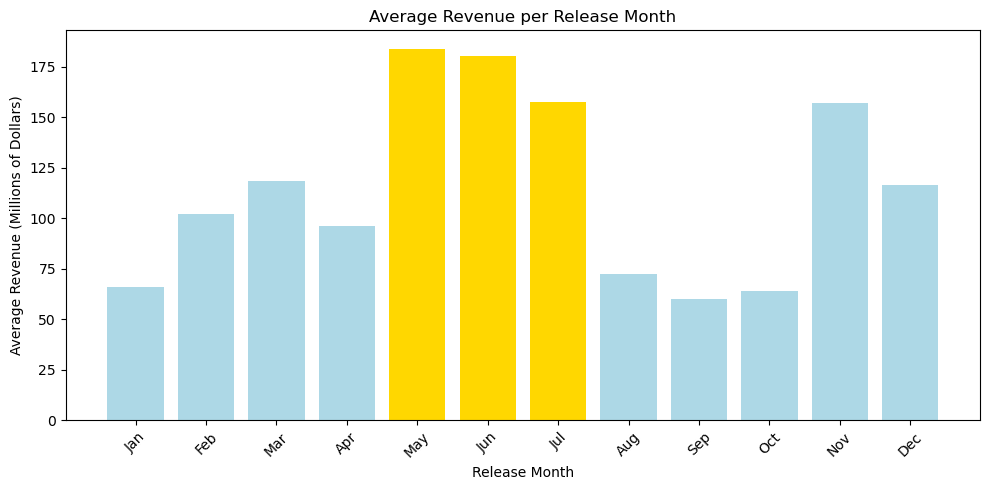

In [44]:
# Assuming revenue_by_month is your DataFrame
top_three_months = revenue_by_month.nlargest(3, 'revenue')['release_month'].values

# Correct the colors list comprehension to iterate over the release_month column
colors = ['gold' if month in top_three_months else 'lightblue' for month in revenue_by_month['release_month']]

# Define x and y for plotting
x = revenue_by_month['release_month']
y = revenue_by_month['revenue']

# Create the bar chart with sorted x and y
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x, y, color=colors)
ax.set_title('Average Revenue per Release Month')
ax.set_xlabel('Release Month')
ax.set_ylabel('Average Revenue (Millions of Dollars)')

# Set x-ticks to ensure they are ordered correctly
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=45)

plt.tight_layout();

H0: Null Hypothesis: The mean revenue is the same across all release months.
Alternative Hypothesis: At least one release month has a different mean revenue.
H1: 

In [51]:
# Group the data by valid genres and collect ratings
rec3_grouped_data = df_relevant.groupby('release_month')['revenue'].apply(list)

# Extract groups for ANOVA
rec3_groups = [revenue for revenue in rec3_grouped_data]

# Perform the ANOVA test if there are valid groups
f_statistic, p_value = stats.f_oneway(*rec3_groups)

# Interpret the results
alpha = 0.05  # Significance level
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences between genre ratings.")
else:
    print("Fail to reject the null hypothesis: No significant differences between genre ratings.")

F-statistic: 7.986870778331587
P-value: 8.783683654662952e-14
Reject the null hypothesis: There are significant differences between genre ratings.


In [52]:
# Run Tukey's HSD test
rec3_tk_hsd = pairwise_tukeyhsd(endog=df_relevant['revenue'], 
                            groups=df_relevant['release_month'], 
                            alpha=0.05)

# Display the summary of results
print(rec3_tk_hsd.summary())

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
group1 group2     meandiff    p-adj       lower          upper      reject
--------------------------------------------------------------------------
   Apr    Aug  -23328370.1659 0.9966  -96191235.5925  49534495.2607  False
   Apr    Dec   20626708.1119 0.9976  -46583361.5887  87836777.8125  False
   Apr    Feb    6017958.5419    1.0  -71264780.8179  83300697.9017  False
   Apr    Jan  -30065379.4829 0.9848 -108820303.3044  48689544.3387  False
   Apr    Jul   61220471.2406 0.2319  -13244671.6327 135685614.1139  False
   Apr    Jun   84436890.7608   0.01   10703470.3724 158170311.1492   True
   Apr    Mar   22340087.3918 0.9977  -50709865.2463  95390040.0298  False
   Apr    May   87783979.3995  0.012   10077769.8048 165490188.9942   True
   Apr    Nov   61129835.5757 0.2101  -12014986.1147  134274657.266  False
   Apr    Oct  -31973558.9693 0.9486 -103140602.7258  39193484.7872  False
   Apr    Sep  -35884549.

In [53]:
"""
This table shows that there is a significant difference in revenue
between movies released in May, June, and July compared to September
and October but not with each other or the other calendar months, meaning
that the movie can be released any time during this time period (May-July)
and perform similarly.
"""

rec3_results = pd.DataFrame(data=rec3_tk_hsd._results_table.data[1:], 
                          columns=rec3_tk_hsd._results_table.data[0])
rec3_results.query('reject == True and (group1 == "May" or group1 == "Jun" or group1 == "Jul")')

,group1,group2,meandiff,p-adj,lower,upper,reject
49,Jul,Oct,-9.319403e+07,0.0012,-1.645846e+08,-2.180344e+07,True
50,Jul,Sep,-9.710502e+07,0.0010,-1.708548e+08,-2.335521e+07,True
54,Jun,Oct,-1.164104e+08,0.0000,-1.870375e+08,-4.578343e+07,True
55,Jun,Sep,-1.203214e+08,0.0000,-1.933324e+08,-4.731052e+07,True
61,May,Oct,-1.197575e+08,0.0000,-1.945226e+08,-4.499248e+07,True
62,May,Sep,-1.236685e+08,0.0000,-2.006895e+08,-4.664754e+07,True


Recommendation 3: Release the movie in May, June, or July